## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt
import aesara as at

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler, RobustScaler
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.compose import ColumnTransformer

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load Data

In [3]:
df_train = pd.read_csv(r"C:\Users\HG749BX\OneDrive - EY\Documents\Python\age-related-conditions\train.csv")
df_test = pd.read_csv(r"C:\Users\HG749BX\OneDrive - EY\Documents\Python\age-related-conditions\test.csv")
df_greeks = pd.read_csv(r"C:\Users\HG749BX\OneDrive - EY\Documents\Python\age-related-conditions\greeks.csv")

print('No. of records for train : {}'.format(df_train.shape))
print('No. of records for test : {}'.format(df_test.shape))
print('No. of records for greeks : {}'.format(df_greeks.shape))

No. of records for train : (617, 58)
No. of records for test : (5, 57)
No. of records for greeks : (617, 6)


## Partition 
The goal is to select all rows of the offending column which are NaN and then predict them using the corresponding rows of the other columns

## Scale

In [27]:
def split_by_nan(df,c):
    # drop columns
    df = df_train.drop(['Id','EJ','Class'],axis=1).copy()
    if c == 'BQ':
        df = df.drop(['EL'], axis=1).copy()
    elif c== 'EL':
        df = df.drop(['BQ'], axis=1).copy()
    # subselect
    nan_data = df[ df[c].isna() ].copy()
    non_nan_data = df[ ~df[c].isna() ].copy()
    # return
    return nan_data, non_nan_data

In [49]:
# focus on the numerical values for now, try fitting model
fill_data, train_data = split_by_nan(df_train, 'BQ')

target = train_data['BQ'].to_numpy()
train_data = train_data.drop('BQ', axis=1).copy()

mms = RobustScaler().fit_transform(train_data)

## Mask

In [50]:
x_missing = np.isnan(mms)
X_train = np.ma.masked_array(mms, mask=x_missing)
missing_shape = np.shape(x_missing)
col_shape = np.shape(mms)[1]

## Model
Maybe I am doing this slightly wrong?
https://discourse.pymc.io/t/missing-data-imputation-obscurities/8617

In [55]:
with pm.Model() as walle: 
    # use Mutable Data maybe
    y = pm.MutableData("y", target)
    data = pm.MutableData("data", X_train)
    # impute
    μMask = pm.Normal("μMask", mu=0, sigma=10, shape=(col_shape,))
    μ = pm.Normal("μ", mu=μMask, sigma=10, shape=(col_shape,))
    ϵ = pm.Normal("ϵ", mu=0, sigma=10)
    # response
    response = pm.Normal("response", mu=pm.math.dot(data, μ) + ϵ, sigma=10, observed=y)

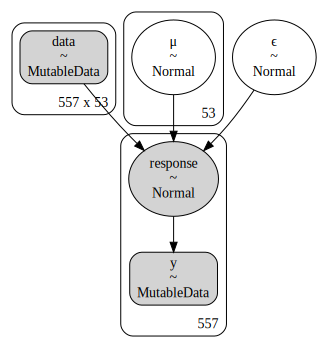

In [56]:
pm.model_to_graphviz(walle)

In [57]:
with walle:
    walleTrace = pm.sample(
        draws=1000,
        tune=2000,
        idata_kwargs={"log_likelihood": True},
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'μ': array([-0.88016349, -0.8986088 , -0.86845637,  0.13884633, -0.11916455,
       -0.85707462,  0.02751156, -0.52788908, -0.92032607,  0.60198203,
        0.67734856, -0.7607615 , -0.22662946,  0.08448424,  0.5118256 ,
       -0.73362906, -0.91062513,  0.36293248,  0.50992732,  0.46269648,
       -0.15478118, -0.04441708,  0.8997429 , -0.345673  ,  0.06258732,
       -0.37103885,  0.3786831 ,  0.32299115,  0.06013851,  0.05111996,
        0.74784612,  0.43833709,  0.46012189,  0.83741429,  0.38650987,
       -0.7223326 ,  0.59212802,  0.72839211,  0.77703693,  0.29584159,
       -0.84400143,  0.74722667, -0.39419154,  0.64128756, -0.16000688,
        0.0192536 , -0.30877069,  0.90746229, -0.83563368, -0.50645694,
       -0.47877706,  0.69154333, -0.36638404]), 'ϵ': array(0.58357251)}

Initial evaluation results:
{'μ': -170.83, 'ϵ': -3.22, 'response': nan}